In [1]:
# https://github.com/bonlime/keras-deeplab-v3-plus
from model import Deeplabv3
deeplab_model = Deeplabv3(input_shape=(384, 384, 3), classes=4)  

/Users/keen/miniconda3/envs/py37-ml-basic/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/keen/miniconda3/envs/py37-ml-basic/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/keen/miniconda3/envs/py37-ml-basic/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/Users/keen/miniconda3/en

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [2]:
deeplab_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 384, 384, 3)  0                                            
__________________________________________________________________________________________________
Conv (Conv2D)                   (None, 192, 192, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
Conv_BN (BatchNormalizationV1)  (None, 192, 192, 32) 128         Conv[0][0]                       
__________________________________________________________________________________________________
Conv_Relu6 (Activation)         (None, 192, 192, 32) 0           Conv_BN[0][0]                    
__________________________________________________________________________________________________
expanded_c

In [3]:

deeplab_model.predict()

TypeError: predict() missing 1 required positional argument: 'x'

In [5]:
import cv2

cap = cv2.VideoCapture(0)
ok, frame = cap.read()
if ok:
    img = cv2.resize(frame, (384,384))
    cv2.imshow("img", img)

In [2]:
import cv2
img = cv2.imread("keras-deeplab-v3-plus/img.jpeg")

In [5]:
cv2.namedWindow("img", cv2.WINDOW_NORMAL)
cv2.imshow("img",img)

error: OpenCV(4.1.2) /Users/travis/build/skvark/opencv-python/opencv/modules/highgui/src/window.cpp:376: error: (-215:Assertion failed) size.width>0 && size.height>0 in function 'imshow'


In [6]:

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

In [40]:
img = plt.imread("/Users/keen/jupyter-workspace/keras-deeplab-v3-plus/img.jpeg")

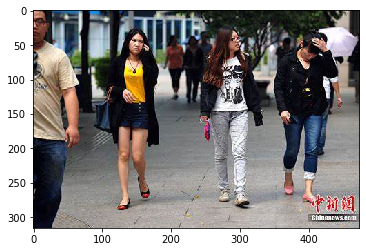

In [41]:
plt.imshow(img)

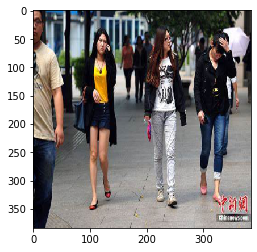

In [46]:
import numpy as np
import cv2
img2 = cv2.resize(img, (384,384))
plt.imshow(img2)
result = deeplab_model.predict(np.reshape(img2, (1,384,384,3)))

# opencv + darknet + deeplab 

In [1]:
import numpy as np
from PIL import Image
from matplotlib import pyplot as plt
from model import Deeplabv3
import cv2
import time
import darknet as dn

net = dn.load_net(str.encode("../learn-cv/darknet/cfg/yolov3-tiny.cfg"), str.encode("../learn-cv/darknet/weights/yolov3-tiny.weights"), 0)
meta = dn.load_meta(str.encode("/Users/keen/jupyter-workspace/learn-cv/darknet/cfg/coco.data"))


# Generates labels using most basic setup.  Supports various image sizes.  Returns image labels in same format
# as original image.  Normalization matches MobileNetV2
deeplab_model = Deeplabv3()

cap = cv2.VideoCapture(0)

cv2.namedWindow("img", cv2.WINDOW_NORMAL)
cv2.startWindowThread()

last_time = time.time()

while True:
    ret, img = cap.read()
    if ret: 
        
        trained_image_width=512 
        mean_subtraction_value=127.5
        image = np.array(img)

        # resize to max dimension of images from training dataset
        w, h, _ = image.shape
        ratio = float(trained_image_width) / np.max([w, h])
        resized_image = np.array(Image.fromarray(image.astype('uint8')).resize((int(ratio * h), int(ratio * w))))

        # apply normalization for trained dataset images
        resized_image = (resized_image / mean_subtraction_value) - 1.

        # pad array to square image to match training images
        pad_x = int(trained_image_width - resized_image.shape[0])
        pad_y = int(trained_image_width - resized_image.shape[1])
        resized_image = np.pad(resized_image, ((0, pad_x), (0, pad_y), (0, 0)), mode='constant')

        # make prediction
        res = deeplab_model.predict(np.expand_dims(resized_image, 0))
        labels = np.argmax(res.squeeze(), -1)

        # remove padding and resize back to original image
        if pad_x > 0:
            labels = labels[:-pad_x]
        if pad_y > 0:
            labels = labels[:, :-pad_y]
        labels = np.array(Image.fromarray(labels.astype('uint8')).resize((h, w)))

#         plt.imshow(labels)
        fl = np.ones((720, 1280, 3)) * labels[:,:,None]

        img = cv2.addWeighted(fl.astype(np.uint8) * 255, 0.5, img, 0.5, 0)
        
        ## darknet
        bboxes = dn.detect(net, meta, img)
        for bbox in bboxes:
            x, y, w, h = bbox[2][0], bbox[2][1], bbox[2][2], bbox[2][3]
            xmin, ymin, xmax, ymax = dn.convertBack(float(x), float(y), float(w), float(h))
            pt1 = (xmin, ymin)
            pt2 = (xmax, ymax)
            # print bbox (notice: color is BGR)
            cv2.rectangle(img, pt1, pt2, (0, 255, 0), 2)
            cv2.putText(img, bbox[0].decode() + " [" + str(round(bbox[1] * 100, 2)) + "]", (pt1[0], pt1[1] + 20), cv2.FONT_HERSHEY_SIMPLEX, 1, [0, 255, 0], 4)
        
        
         # print realtime fps
        current_time = time.time()
        cost_time = current_time - last_time
        fps = 1 / cost_time
        cv2.putText(img, "Cost:{:.2f}s, fps:{:.3f}".format(cost_time, fps), (50,50), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2)
        last_time = current_time
        cv2.imshow("img", img)
#         plt.imshow(img)
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

/Users/keen/miniconda3/envs/py37-ml-basic/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/keen/miniconda3/envs/py37-ml-basic/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/keen/miniconda3/envs/py37-ml-basic/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/Users/keen/miniconda3/en

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


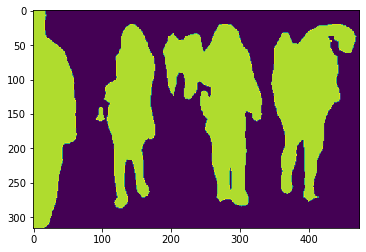

In [49]:
plt.imshow(labels)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


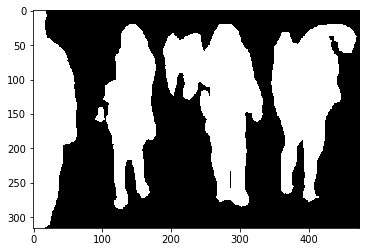

In [63]:
plt.imshow(np.ones((316, 474, 3)) * labels[:,:,None])

fl = np.ones((316, 474, 3)) * labels[:,:,None]

In [51]:
labels3 = labels[:,:,np.newaxis]

In [74]:
# l = np.array(labels).reshape((316, 474, 1))
fl[100,150]
# plt.imshow(fl/2)
# plt.imshow(np.add(fl/2, image/2))

array([15., 15., 15.])

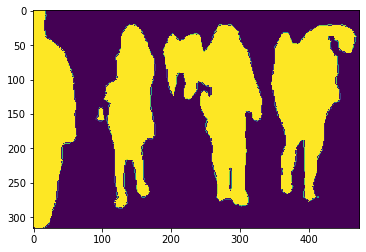

In [43]:
plt.imshow(np.array(labels) * 17)

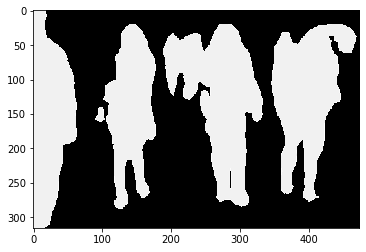

In [116]:
plt.imshow(fl.astype(np.uint8)*255)

In [109]:
type(image)

numpy.ndarray

float64
uint8


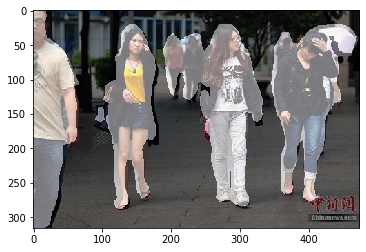

In [118]:
# img1=cv2.imread('1.jpg')
# img2=cv2.imread('2.jpg')
import cv2

print(fl.dtype)
print(image.dtype)
dst = cv2.addWeighted(fl.astype(np.uint8)*255,0.5,image,0.5,0)
plt.imshow(dst)


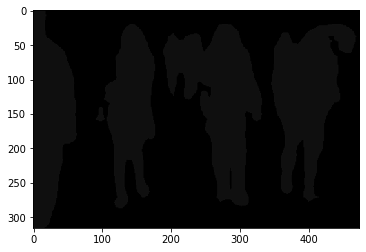

In [106]:
plt.imshow(np.uint8(fl))

In [95]:
print(ffl.dtype)
print(image.dtype)

uint8
uint8


In [27]:
deeplab_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 384, 384, 3)  0                                            
__________________________________________________________________________________________________
Conv (Conv2D)                   (None, 192, 192, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
Conv_BN (BatchNormalizationV1)  (None, 192, 192, 32) 128         Conv[0][0]                       
__________________________________________________________________________________________________
Conv_Relu6 (Activation)         (None, 192, 192, 32) 0           Conv_BN[0][0]                    
__________________________________________________________________________________________________
expanded_c